# End-to-End Camera Calibration

Simulated data to support the idea of end-to-end camera transformation.

For details on the idea, see [the doc](https://docs.google.com/document/d/1-ikSOxtrC4HLzd8xBdokjfMbbz0616eOBsco-bDk3os/edit)

### Imports

In [239]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import cv2
np.set_printoptions(precision=2, floatmode='fixed', suppress=True, threshold=10)

### Real world points

In [240]:
# +/- 1 meter side to side, 1-3 meters up

X, Y = np.meshgrid(np.linspace(-1, 1, 5), np.linspace(1, 3, 5))
X, Y = X.reshape(1, -1), Y.reshape(1, -1)

# three meters away
Z = 3 * np.ones_like(X)

XYZ = np.hstack((X.T,Y.T,Z.T))
print(XYZ)
XZ = np.hstack((X.T, Z.T))
print(XZ)

[[-1.00  1.00  3.00]
 [-0.50  1.00  3.00]
 [ 0.00  1.00  3.00]
 ...
 [ 0.00  3.00  3.00]
 [ 0.50  3.00  3.00]
 [ 1.00  3.00  3.00]]
[[-1.00  3.00]
 [-0.50  3.00]
 [ 0.00  3.00]
 ...
 [ 0.00  3.00]
 [ 0.50  3.00]
 [ 1.00  3.00]]


### Camera intrinsics and pose

In [241]:
# calibration matrix
K = np.array([[500.0, 0.0, 250.0], [0.0, 500.0, 250.0], [0.0, 0.0, 1.0]])

# distortion coefficients (k1, k2, p1, p2, k3)
# A LOT of distortion, in order to see it work.
distCoeffs = np.array([1.5, -0.95, -0.005, 0.0025, 1.16])
# distCoeffs = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

# camera rotation. in camera coords, pitch up is along x; 0.5 rad is a reasonable pitch
rvec = np.array([0.5, 0.0, 0.0])
# no camera translation
tvec = np.array([0.0, 0.0, 0.0])

### Project points to pixels, (u, v)

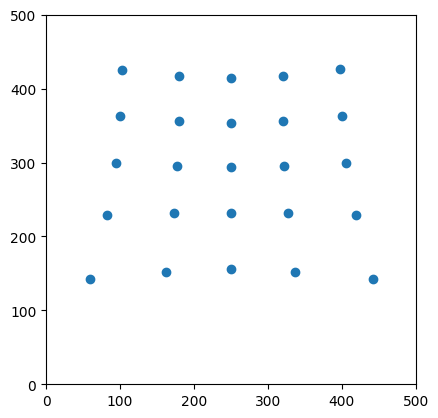

In [242]:
U_dist, _ = cv2.projectPoints(XYZ, rvec, tvec, K, distCoeffs)
uv = U_dist[:, 0]
plt.scatter(uv.T[0], uv.T[1])
plt.gca().set_aspect('equal')
plt.xlim(0,500)
plt.ylim(0,500)
plt.show()

### Add some noise to the uv observations

In [243]:
uv += np.random.normal(0, 5, uv.shape)
print(uv) 

[[ 61.11 148.66]
 [157.08 155.57]
 [253.00 155.15]
 ...
 [251.10 412.18]
 [318.88 419.11]
 [392.34 429.36]]


### Construct some simulated input

In [244]:
# each row is a camera sighting
uvY = np.hstack((uv, Y.T))
print(uvY)

[[ 61.11 148.66   1.00]
 [157.08 155.57   1.00]
 [253.00 155.15   1.00]
 ...
 [251.10 412.18   3.00]
 [318.88 419.11   3.00]
 [392.34 429.36   3.00]]


### Predict XZ (robot-relative Translation2d)  from simulated uvY

In [245]:
# XZ is XY in wpi coords.  uvY is uvZ in wpi coords
uvy_to_xz = interp.RBFInterpolator(uvY, XZ)
predictedXZ = uvy_to_xz(uvY)
print(predictedXZ)

[[-1.00  3.00]
 [-0.50  3.00]
 [ 0.00  3.00]
 ...
 [ 0.00  3.00]
 [ 0.50  3.00]
 [ 1.00  3.00]]


### RBFInterpolator performance

This shows about 10 us on my laptop, which is a 3 GHz i7; a Raspberry Pi 4 runs at 1.8 GHz, so say it's half as fast, so the interpolation might take 20 us.

Compare this to the previous design which took 13 **milliseconds** to undistort the whole frame, and then the RoboRIO (much slower) would do the pose transformation.

In [251]:
import time

t1 = time.time()
n = 100000
for i in range(n):
    uvy_to_xz([[157.08, 155.57, 1.00]])
t2 = time.time()
print(f"duration (sec) {(t2 - t1):.2f}")
print(f"duration per prediction (microsec) {(1e6*(t2-t1)/n):.2f}")

duration (sec) 0.76
duration per prediction (microsec) 7.59


### References

see more on [projectpoints](https://forum.opencv.org/t/understanding-the-functions-projectpoints-and-undistortpoints/10847)

and an example of [interpolation](https://stackoverflow.com/questions/37872171/how-can-i-perform-two-dimensional-interpolation-using-scipy)